# funds and holdings from hedgefollow.com

In [ ]:
import pandas as pd
import bs4

from selenium import webdriver 
from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(executable_path="./chromedriver",options=chrome_options)



In [64]:
url = "https://hedgefollow.com/top-hedge-funds.php"

driver.get(url)

html_content = driver.page_source.encode("utf-8")

soup = bs4.BeautifulSoup(html_content)

top_hedge_funds_links = []

for a in soup.find_all('a', href=True):
    link = "https://www.hedgefollow.com"+a['href']
    if "/funds/" in link and link not in top_hedge_funds_links :
        top_hedge_funds_links.append(link)




In [65]:
top_hedge_funds_links

['https://www.hedgefollow.com/funds/Whale+Rock+Capital+Management',
 'https://www.hedgefollow.com/funds/Scge+Management',
 'https://www.hedgefollow.com/funds/Firsthand+Capital+Management',
 'https://www.hedgefollow.com/funds/Tybourne+Capital+Management',
 'https://www.hedgefollow.com/funds/Atika+Capital+Management',
 'https://www.hedgefollow.com/funds/Crosslink+Capital',
 'https://www.hedgefollow.com/funds/Kora+Management',
 'https://www.hedgefollow.com/funds/Night+Owl+Capital+Management',
 'https://www.hedgefollow.com/funds/SRS+Investment+Management',
 'https://www.hedgefollow.com/funds/Antipodean+Advisors',
 'https://www.hedgefollow.com/funds/Coatue+Management',
 'https://www.hedgefollow.com/funds/Ithaka+Group',
 'https://www.hedgefollow.com/funds/Kerrisdale+Advisers',
 'https://www.hedgefollow.com/funds/Dorsey+Asset+Management',
 'https://www.hedgefollow.com/funds/Light+Street+Capital+Management',
 'https://www.hedgefollow.com/funds/Crestwood+Capital+Management',
 'https://www.hedge

## Append dataframes

In [182]:

funds = pd.DataFrame()
holdings = pd.DataFrame()

for fund_id, hedgefund_link in enumerate(top_hedge_funds_links):
    driver.get(hedgefund_link)
    tables = pd.read_html(driver.page_source.encode("utf-8"))

    fund_summary_df = tables[0]
    fund_holdings_df = tables[1]
    
    fund_holdings_df["fund_id"] = fund_id
    fund_holdings_df["fund"] = fund_summary_df["Hedge Fund"][0]
    
    funds = funds.append(fund_summary_df)
    holdings = holdings.append(fund_holdings_df)


funds_and_holdings = [funds,holdings]

In [184]:
import pickle
with open("funds_and_holdings.pkl","wb") as f:
        pickle.dump(funds_and_holdings,f)

# Clean and transform

In [1]:
import pickle
with open("funds_and_holdings.pkl","rb") as f:
        funds,holdings = pickle.load(f)

In [2]:
def value_to_float(x):

    if type(x) == float or type(x) == int:
        return x
    x = x.replace("$","")
    if 'k' in x:
        if len(x) > 1:
            return float(x.replace('k', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

def percentage_to_float(x):
    x = x.replace("%","")
    if x == "NEW" or x == "<.01":
        return 0.00
    return float(x) / 100

In [6]:
holdings.drop(["Ownership History","Price History"],axis=1,inplace=True)

holdings["Shares"] = holdings["Shares"].apply(value_to_float)
holdings["Value"] = holdings["Value"].apply(value_to_float)
holdings["Change"] = holdings["Change"].apply(value_to_float)

holdings["Date"] = pd.to_datetime(holdings["Date"],format="%Y-%m-%d")

holdings["change"] = holdings["% Change"].apply(percentage_to_float)
holdings["portfolio"] = holdings["% of Portfolio"].apply(percentage_to_float)

holdings.drop(["% Change","% of Portfolio"],axis=1,inplace=True)

In [7]:
holdings

,Stock,Company Name,Shares,Value,Change,Date,fund_id,fund,change,portfolio
0,AMZN,Amazon Com Inc,323250.0,1.020000e+09,28170.0,2020-09-30,0,Whale Rock Capital Management,0.0955,0.0695
1,SHOP,Shopify Inc,747770.0,7.649400e+08,-42450.0,2020-09-30,0,Whale Rock Capital Management,-0.0537,0.0522
2,TSLA,Tesla Mtrs Inc,1700000.0,7.312800e+08,-1360000.0,2020-09-30,0,Whale Rock Capital Management,-0.4441,0.0499
3,ZM,Zoom Video Communications In Cl A,1500000.0,7.038600e+08,-489660.0,2020-09-30,0,Whale Rock Capital Management,-0.2464,0.0480
4,JD,Jd Com Inc,6740000.0,5.232300e+08,1520000.0,2020-09-30,0,Whale Rock Capital Management,0.2916,0.0357
...,...,...,...,...,...,...,...,...,...,...
48,TLGT,Teligent Inc New,0.0,0.000000e+00,-523120.0,2019-12-31,19,venBio Select Advisor,-1.0000,0.0000
49,SAGE,Sage Therapeutics Inc,0.0,0.000000e+00,-1000000.0,2020-06-30,19,venBio Select Advisor,-1.0000,0.0000
50,RCKT,Rocket Pharmaceuticals Inc Com,0.0,0.000000e+00,-285710.0,2019-12-31,19,venBio Select Advisor,-1.0000,0.0000
51,RVMD,Revolution Medicines Inc Com,0.0,0.000000e+00,-304000.0,2020-09-30,19,venBio Select Advisor,-1.0000,0.0000


# Clustering and PCA

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
df = holdings.drop(["Stock","Company Name","fund","Date"],axis=1)

In [10]:
df = df.astype(float)
X_std = StandardScaler().fit_transform(df)

In [11]:
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(X_std)

In [12]:
principalComponents

array([[ 2.30633378, -2.72691425,  1.29325951, -0.04423073, -1.57898886,
        -2.40780077],
       [ 1.59882745, -2.10105651,  1.2514015 , -0.3112456 , -1.18607594,
        -1.61949166],
       [ 1.3339569 , -2.3359044 ,  1.14793622, -0.23303563, -1.77710912,
        -0.90770396],
       ...,
       [-0.87659753,  0.89970489, -1.26591427,  0.40828094, -0.17927471,
        -0.21534221],
       [-0.88241023,  0.89489914, -1.2665107 ,  0.41156208, -0.18716263,
        -0.21100237],
       [-1.29428942,  0.55437169, -1.30877275,  0.64405802, -0.74608842,
         0.09651136]])

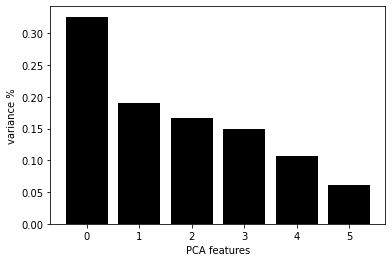

In [13]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

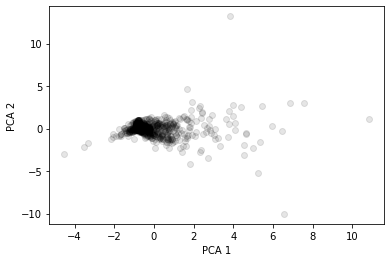

In [14]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

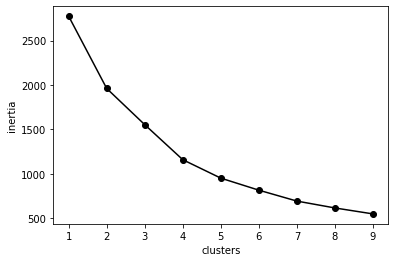

In [15]:
ks = range(1, 10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:3])
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [16]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:3])

KMeans(n_clusters=4)

In [17]:
PCA_components.iloc[:,:3]

,0,1,2
0,2.306334,-2.726914,1.293260
1,1.598827,-2.101057,1.251402
2,1.333957,-2.335904,1.147936
3,1.471261,-2.037335,1.196388
4,3.010104,-0.735663,1.148279
...,...,...,...
672,-0.952048,0.837325,-1.273656
673,-1.103605,0.712023,-1.289207
674,-0.876598,0.899705,-1.265914
675,-0.882410,0.894899,-1.266511


In [18]:
groups = model.predict(PCA_components.iloc[:,:3])
df["group"] = groups

In [19]:
df

,Shares,Value,Change,fund_id,change,portfolio,group
0,323250.0,1.020000e+09,28170.0,0.0,0.0955,0.0695,1
1,747770.0,7.649400e+08,-42450.0,0.0,-0.0537,0.0522,0
2,1700000.0,7.312800e+08,-1360000.0,0.0,-0.4441,0.0499,0
3,1500000.0,7.038600e+08,-489660.0,0.0,-0.2464,0.0480,0
4,6740000.0,5.232300e+08,1520000.0,0.0,0.2916,0.0357,1
...,...,...,...,...,...,...,...
48,0.0,0.000000e+00,-523120.0,19.0,-1.0000,0.0000,2
49,0.0,0.000000e+00,-1000000.0,19.0,-1.0000,0.0000,2
50,0.0,0.000000e+00,-285710.0,19.0,-1.0000,0.0000,2
51,0.0,0.000000e+00,-304000.0,19.0,-1.0000,0.0000,2


In [20]:
df = df.merge(holdings[["fund_id","fund"]],on="fund_id")

funds_groups = df.groupby(["fund_id"])\
                 .agg({
                        "Value":"sum",
                        "Change":"sum",
                        "group":"min",
                        "fund":"min",

                    })
    
funds_groups

,Value,Change,group,fund
fund_id,,,,
0.0,7.802936e+11,8.491792e+08,0,Whale Rock Capital Management
1.0,2.760173e+11,-2.402509e+08,0,Scge Management
3.0,1.827135e+11,-1.345254e+09,0,Tybourne Capital Management
4.0,4.325436e+10,1.100624e+08,0,Atika Capital Management
5.0,1.359474e+10,-4.706961e+07,0,Crosslink Capital
6.0,7.687890e+09,-1.255500e+07,0,Kora Management
7.0,1.537136e+10,2.419200e+06,0,Night Owl Capital Management
8.0,2.486185e+11,-7.732687e+08,0,SRS Investment Management
9.0,3.005970e+09,-3.453890e+06,0,Antipodean Advisors


In [37]:
diff_groups = funds_groups.groupby(["group"]).agg({
    "Value":"mean",
    "Change":"mean",
})
diff_groups

,Value,Change
group,,
0,2.203112e+11,2.391732e+08
1,4.518813e+11,7.453803e+08
2,1.883860e+10,-1.629408e+07


In [38]:
# Value is size of portfolio
# Change is change in portfolio 

diff_groups[["Value","Change"]] = round(diff_groups[["Value","Change"]] / 10e6)
diff_groups.columns = ["Value $M","Change $M"]
diff_groups

,Value $M,Change $M
group,,
0,22031.0,24.0
1,45188.0,75.0
2,1884.0,-2.0
